# QC - bulk methylation

## Package loading and definitions

In [63]:
register.source(here::here("code/init.R"))
theme_set(tgppt::theme_arial(8))
rl <- alutil::rl

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/track_stats.csv'



## Probe design

## Breakdown of probes

Get capture regions:

In [2]:
regions <- "intervs.captPBAT_probes.ES_EB_V1"
regs_df <- gintervals.load(regions) %>% as_tibble()

Get capture probes:

In [3]:
probes <- fread(here("data/probes_V1.csv"))
probes_span <- probes %>% select(chrom, start, end, probe_id=id) %>% gintervals.centers() %>% mutate(start = start - 150, end = end + 150)

Save capture probes:

In [4]:
probes %>% select(chrom, start, end, start_reg, end_reg, genomic_seq, seq, type=reg_type) %>% fwrite(here("Mukamel_et_al_2020_EB_DNMT/PBAT_capture_probes.tsv"), sep="\t")

Get enhancer definitions:

In [5]:
enh_intervs <- define_enhancer_intervs() %cache_df% here("output/enh_intervs.csv") %>% as_tibble()

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/enh_intervs.csv'



Get promoter definitions:

In [6]:
prom_intervs <- gpatterns::gpatterns.get_promoters(upstream = 1e3, downstream=50) %>% as_tibble()

Annotate regions:

In [7]:
probes_annot <- probes_span %>% 
    gintervals.neighbors1(prom_intervs) %>% 
    mutate(dist_prom = dist) %>% 
    select(-(chrom1:dist)) %>% 
    gintervals.neighbors1(enh_intervs) %>% 
    mutate(dist_enh = dist) %>% 
    select(-(chrom1:dist)) %>% 
    mutate(type = case_when(dist_prom == 0 ~ "Promoter", dist_enh == 0 ~ "Enhancer", TRUE ~ "Background"))

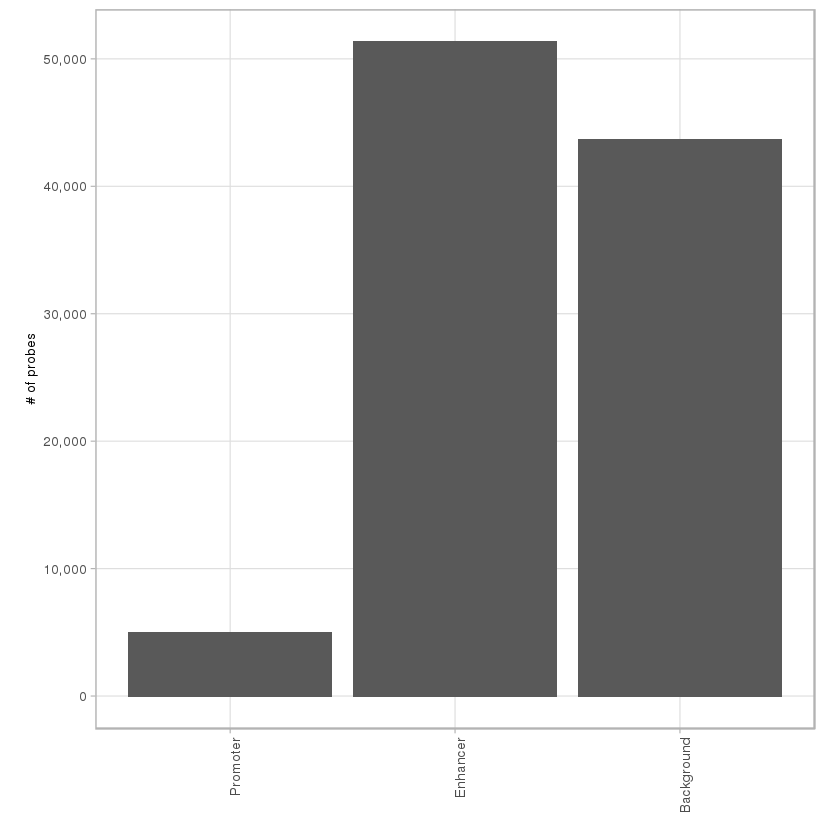

In [8]:
p <- probes_annot %>% count(type) %>% mutate(type = factor(type, levels = c("Promoter", "Enhancer", "Background"))) %>% ggplot(aes(x=type, y=n)) + geom_col() + scale_y_continuous(labels=scales::comma) + xlab("") + ylab("# of probes") + theme(aspect.ratio=1) + vertical_labs()
p

Add to ppt:

In [9]:
plot_gg_ppt(p, here("figures/probes-coverage-stats.pptx"), width = 4, height = 5)

## WGBS E8.5

### Coverage

In [10]:
wgbs_track <- "wgPBAT.E8_5"
wgbs_df <- gextract(c(glue("{wgbs_track}.cov"), glue("{wgbs_track}.meth")), intervals="intervs.global.seq_CG", iterator = "intervs.global.seq_CG", colnames = c("cov", "meth")) %>% arrange(intervalID) %>% select(-intervalID) %>% as_tibble()
wgbs_df <- wgbs_df %>% mutate(cov = ifelse(is.na(cov), 0, cov), meth = ifelse(is.na(meth), 0, meth))
wgbs_cov_counts <- wgbs_df %>% count(cov)
med_cov <- median(wgbs_df$cov)

Plot:

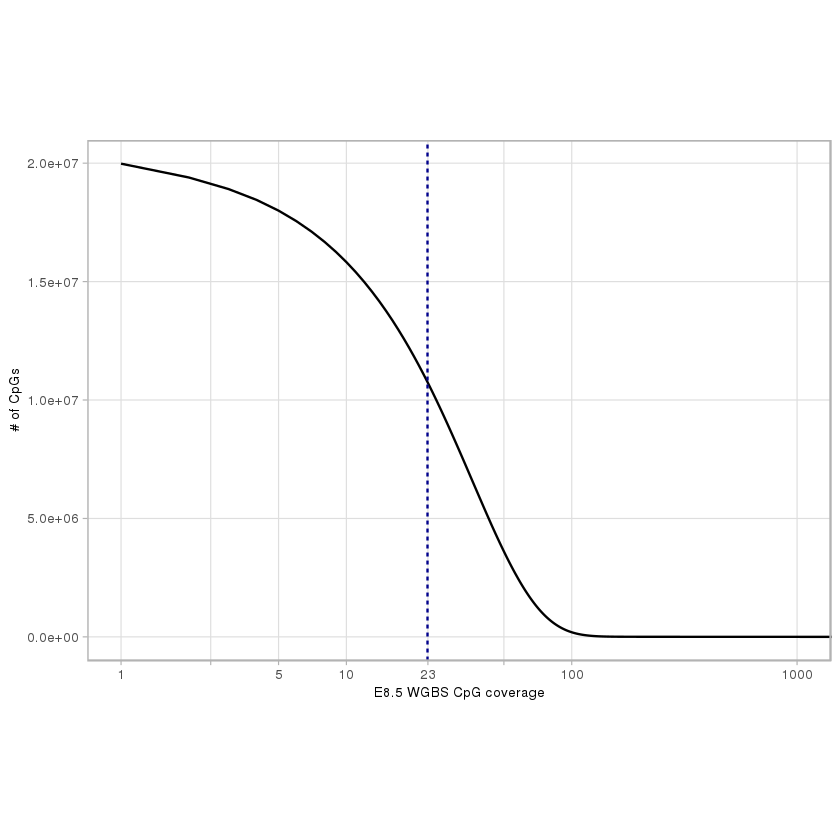

In [11]:
p <- wgbs_cov_counts %>% 
    filter(cov > 0) %>% 
    mutate(cum = rev(cumsum(rev(n)))) %>% 
    ggplot(aes(x=cov, y=cum)) + 
        geom_line() + 
        scale_x_log10(breaks=c(1,2.5,5,10, med_cov, 50, 100, 1e3), labels = c(1,'', 5,10,med_cov,'', 100,1000)) + 
        coord_cartesian(xlim=c(1,1e3)) + 
        scale_y_continuous(labels=scales::scientific) + 
        ylab("# of CpGs") + 
        xlab("E8.5 WGBS CpG coverage") + 
        geom_vline(xintercept=med_cov, linetype="dashed", color="darkblue") + 
        theme(aspect.ratio=0.7)
p

Add to ppt:

In [12]:
plot_gg_ppt(p, here("figures/probes-coverage-stats.pptx"), width = 5, height = 4, overwrite = TRUE)

### Methylation distribution on-target vs off-target

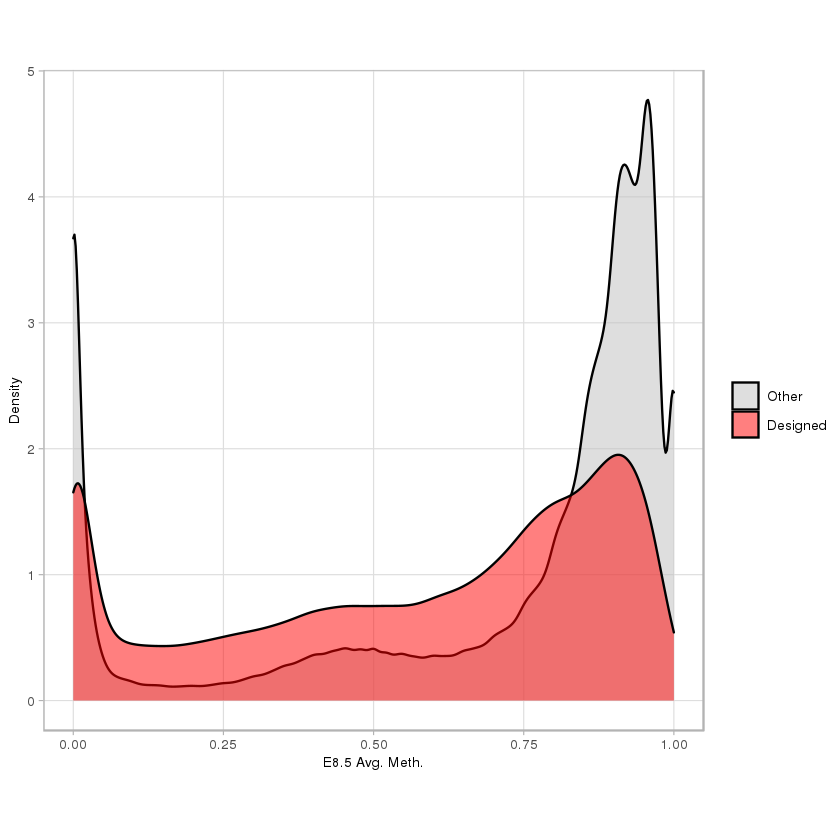

In [13]:
wgbs_df_annot <- wgbs_df %>% 
    filter(cov >= 20) %>% 
    gintervals.neighbors1("intervs.captPBAT_probes.ES_EB_V1") %>% 
    mutate(type = ifelse(is.na(dist) | dist == 0, "Designed", "Other")) %>% 
    select(-(chrom1:dist))
p <- wgbs_df_annot %>% 
    mutate(type = factor(type, levels = c("Other", "Designed"))) %>% 
    arrange(desc(type)) %>% 
    mutate(avg = meth / cov) %>% 
    ggplot(aes(x=avg, fill=type)) + 
        geom_density(alpha=0.5) + 
        scale_fill_manual("", values=c("Designed" = "red", "Other" = "gray")) + 
        theme(aspect.ratio=1) + 
        xlab("E8.5 Avg. Meth.") + 
        ylab("Density")
plot_gg_ppt(p, here("figures/probes-coverage-stats.pptx"), width = 4, height = 4, sep_legend = TRUE)
p

## Distribution of coverage per condition

Get CpGs participating in the model generation:

The criterion is coverage >= 10 in at least 5 samples.

In [68]:
# cpg_meth <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na = 5, rm_meth_cov=FALSE)
cpg_meth <- calc_eb_cpg_meth(from = 0, to = 6, min_cov = 10, max_na = 5, intervals = gintervals.union("intervs.captPBAT_probes.ES_EB_V1", "intervs.captPBAT_probes.ES_EB_V2"), iterator = "intervs.global.seq_CG", cache_fn = here("output/eb_day0_to_day6_cpg_meth_all.tsv"), rm_meth_cov = FALSE)
cpg_cov <- cpg_meth %>% select(chrom, start, end, ends_with("cov"))
colnames(cpg_cov) <- gsub(".cov$", "", colnames(cpg_cov))
colnames(cpg_cov) <- gsub("_tko", "_TKO", colnames(cpg_cov))
colnames(cpg_cov) <- gsub("d0S_", "S_", colnames(cpg_cov))

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/eb_day0_to_day6_cpg_meth_all.tsv'



In [69]:
samp_levels <- c("d0_3a", "d1_3a", "d2_3a", "d3_3a", "d4_3a", "d0_3b",
"d1_3b", "d2_3b", "d3_3b", "d4_3b", "d0_wt", "d1_wt",
"d2_wt", "d3_wt", "d4_wt", "d0_TKO", "d1_TKO", "d2_TKO",
"d3_TKO", "d4_TKO", "S_3a", "S_3b", "S_wt", "S_TKO")
mut_levels <- c("3a", "3b", "wt", "TKO")

In [70]:
samp_levels_all <- c("d0_3a", "d1_3a", "d2_3a", "d3_3a", "d4_3a", "d5_3a", "d6_3a", "d0_3b",
"d1_3b", "d2_3b", "d3_3b", "d4_3b", "d5_3b", "d6_3b", "d0_wt", "d1_wt",
"d2_wt", "d3_wt", "d4_wt", "d5_wt", "d6_wt", "d0_TKO", "d1_TKO", "d2_TKO",
"d3_TKO", "d4_TKO", "S_3a", "S_3b", "S_wt", "S_TKO")#, "N15_d4_3a", "N15_d5_3a", "N15_d4_3b", "N15_d5_3b", "N15_d4_wt", "N15_d5_wt")
mut_levels_all <- c("3a", "3b", "wt", "TKO")

In [71]:
covs_df <- cpg_cov %>% 
    gather("samp_id", "cov", -(chrom:end)) %>% 
    mutate(samp_id = factor(samp_id, levels = samp_levels_all)) %>% 
    filter(!is.na(samp_id)) %>% 
    separate(samp_id, c("day", "mut"), sep="_", remove=FALSE) %>% 
    mutate(mut = factor(mut, levels = mut_levels_all)) %cache_df% here("output/cpg_cov_capt_all.tsv")

Plot coverage distribution:

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 10478 rows containing non-finite values (stat_boxplot).”


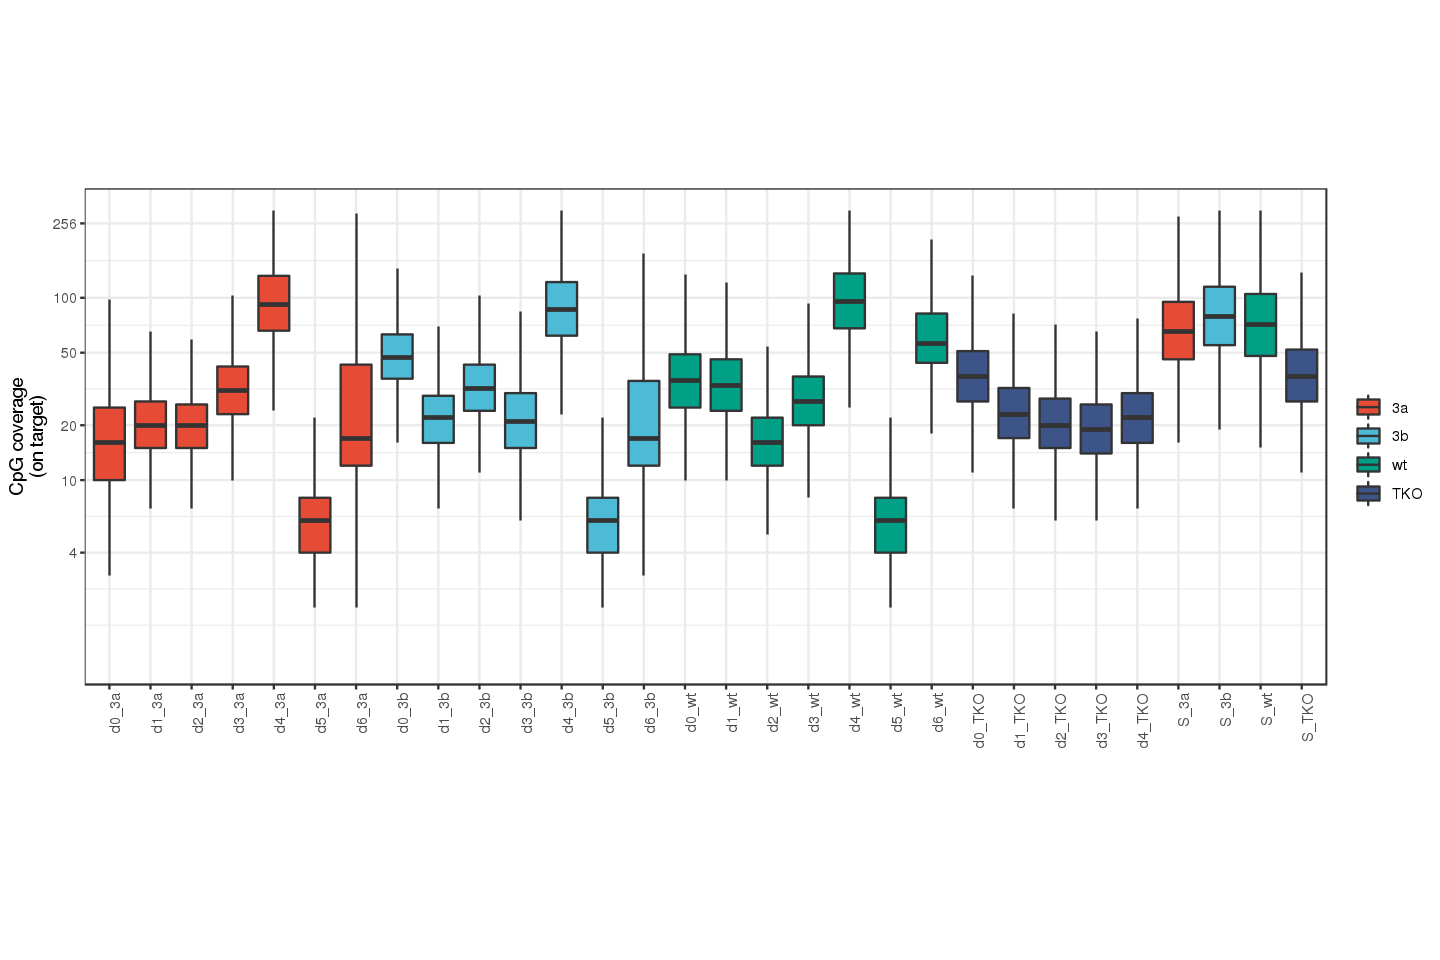

In [72]:
options(repr.plot.width = 12, repr.plot.height = 8)
p <- covs_df %>%         
    ggplot(aes(x=samp_id, y=cov, fill=mut)) + 
        geom_boxplot(outlier.shape=NA) + 
        vertical_labs() + 
        ggsci::scale_fill_npg(name='') + 
        theme(aspect.ratio=0.4) + 
        scale_y_log2(breaks = c(4, 10, 20, 50, 100, 256), limits=c(1,300)) + 
        ylab("CpG coverage\n(on target)") + 
        xlab("")
p + theme_bw() + vertical_labs() + theme(aspect.ratio=0.4) 

Add to ppt:

In [73]:
plot_gg_ppt(p, here("figures/probes-coverage-stats.pptx"), width = 12, height = 5, sep_legend = TRUE, new_slide=TRUE)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 10478 rows containing non-finite values (stat_boxplot).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 10478 rows containing non-finite values (stat_boxplot).”


## Distribution of non-CpGs methylation per condition

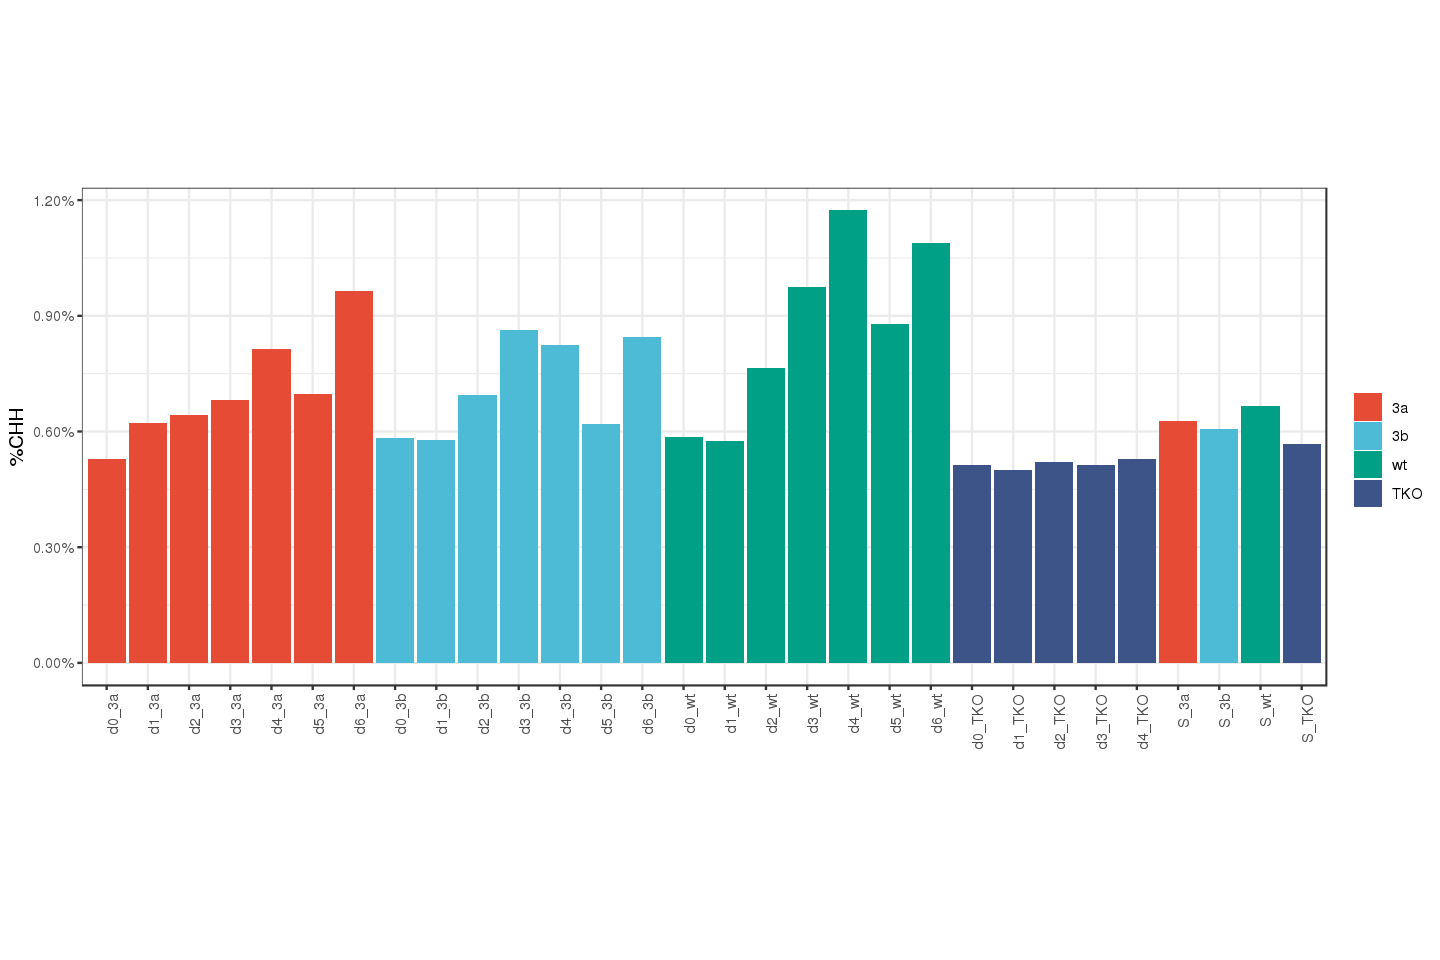

In [22]:
p <- track_stats %>%     
    filter(samp_id %in% samp_levels_all) %>% 
    mutate(mut = factor(mut, levels = mut_levels_all), 
           samp_id = factor(samp_id, levels=samp_levels_all)) %>%     
    group_by(samp_id, mut) %>% 
    summarise(CHH = mean(CHH, na.rm=TRUE)) %>% 
    ggplot(aes(x=samp_id, y=CHH, fill=mut)) + 
    geom_col() + 
    ggsci::scale_fill_npg(name='') + 
    vertical_labs() + 
    xlab('') + 
    ylab('%CHH') + 
    scale_y_continuous(labels=scales::percent) + 
    theme(aspect.ratio=0.4)
p + theme_bw() + vertical_labs() + theme(aspect.ratio=0.4) 

Add to ppt:

In [24]:
plot_gg_ppt(p, here("figures/probes-coverage-stats.pptx"), width = 12, height = 5, sep_legend = TRUE, new_slide=TRUE)

## "On target" statistics

In [132]:
ontar_stats <- calc_on_target_stats() %cache_df% here("output/on_target_stats.csv") %>% as_tibble()
df <- ontar_stats %>% 
    left_join(tracks_key %>% select(track = track_name, capture)) %>% 
    mutate(n_offtar = n - n_ontar) %>% 
    pivot_longer(cols=c("n_ontar", "n_offtar"), names_to="type", values_to="num") %>% 
    mutate(type = case_when(type == "n_ontar" ~ "on target", type == "n_offtar" ~ "off target")) %>%
    filter(samp_id %in% samp_levels_all) %>% 
    mutate(mut = factor(mut, levels = mut_levels_all), samp_id = factor(samp_id, levels=samp_levels_all)) %>% 
    group_by(samp_id, mut, day, type) %>% 
    summarise(num = sum(num, na.rm=TRUE) + 1)

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/on_target_stats.csv'

Joining, by = "track"



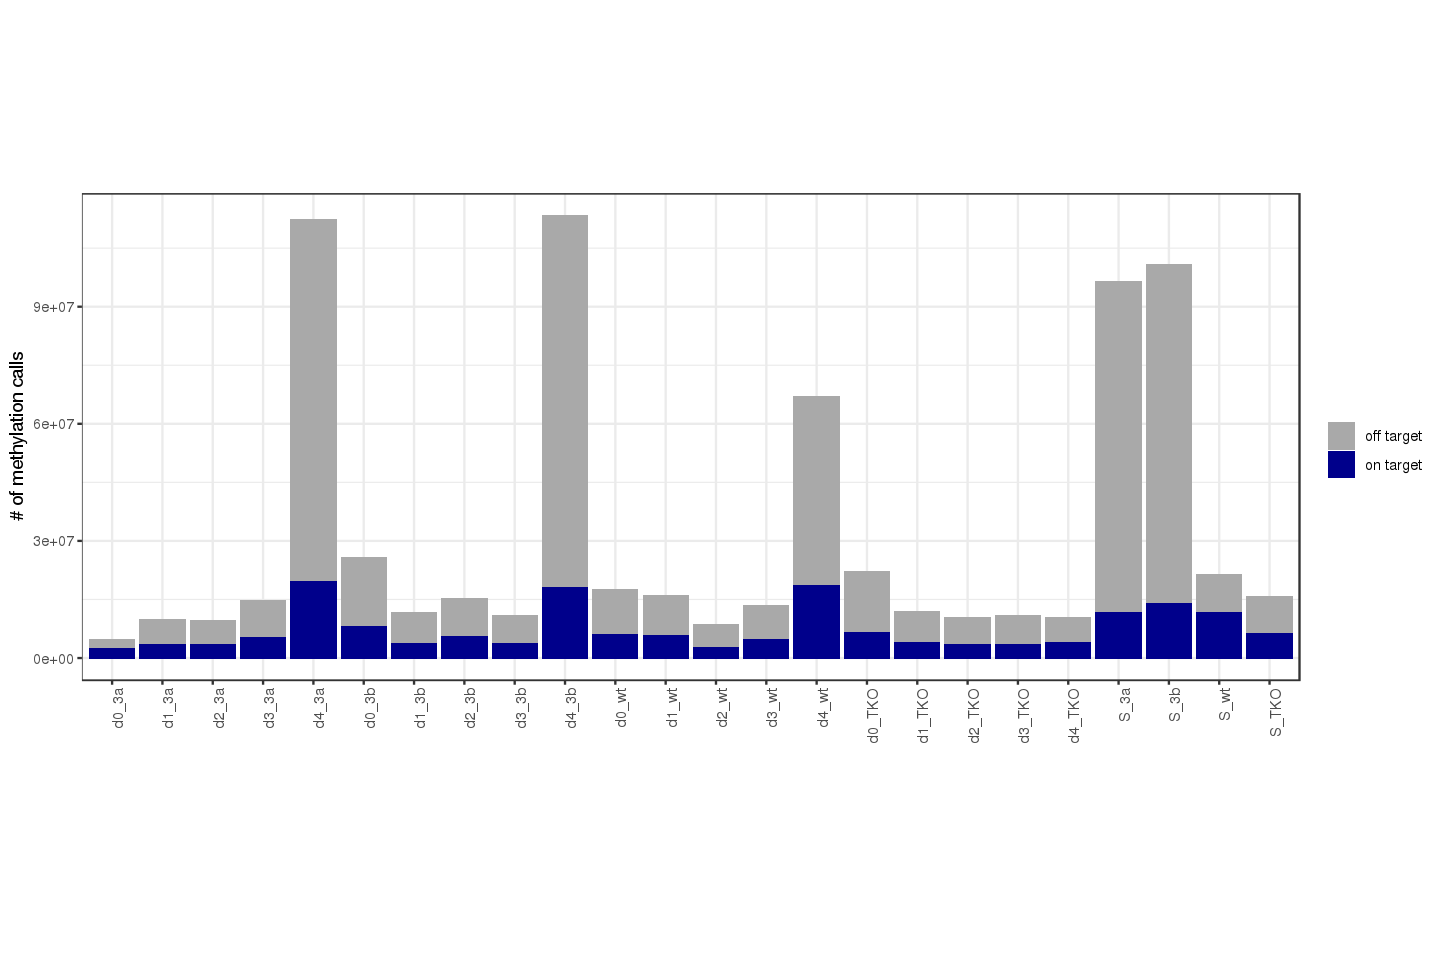

In [139]:
p_0_4 <- df %>%        
    filter(!(day %in% c("d5", "d6"))) %>%    
    ggplot(aes(x=samp_id, y=num, fill=type)) + 
        geom_col() + 
        scale_fill_manual(name="", values=c("on target" = "darkblue", "off target" = "darkgray")) + 
        vertical_labs() + 
        scale_y_continuous(labels=scales::scientific) +         
        xlab('') + 
        ylab('# of methylation calls') +         
        theme(aspect.ratio=0.4)
p_0_4 + theme_bw() + vertical_labs() + theme(aspect.ratio=0.4)

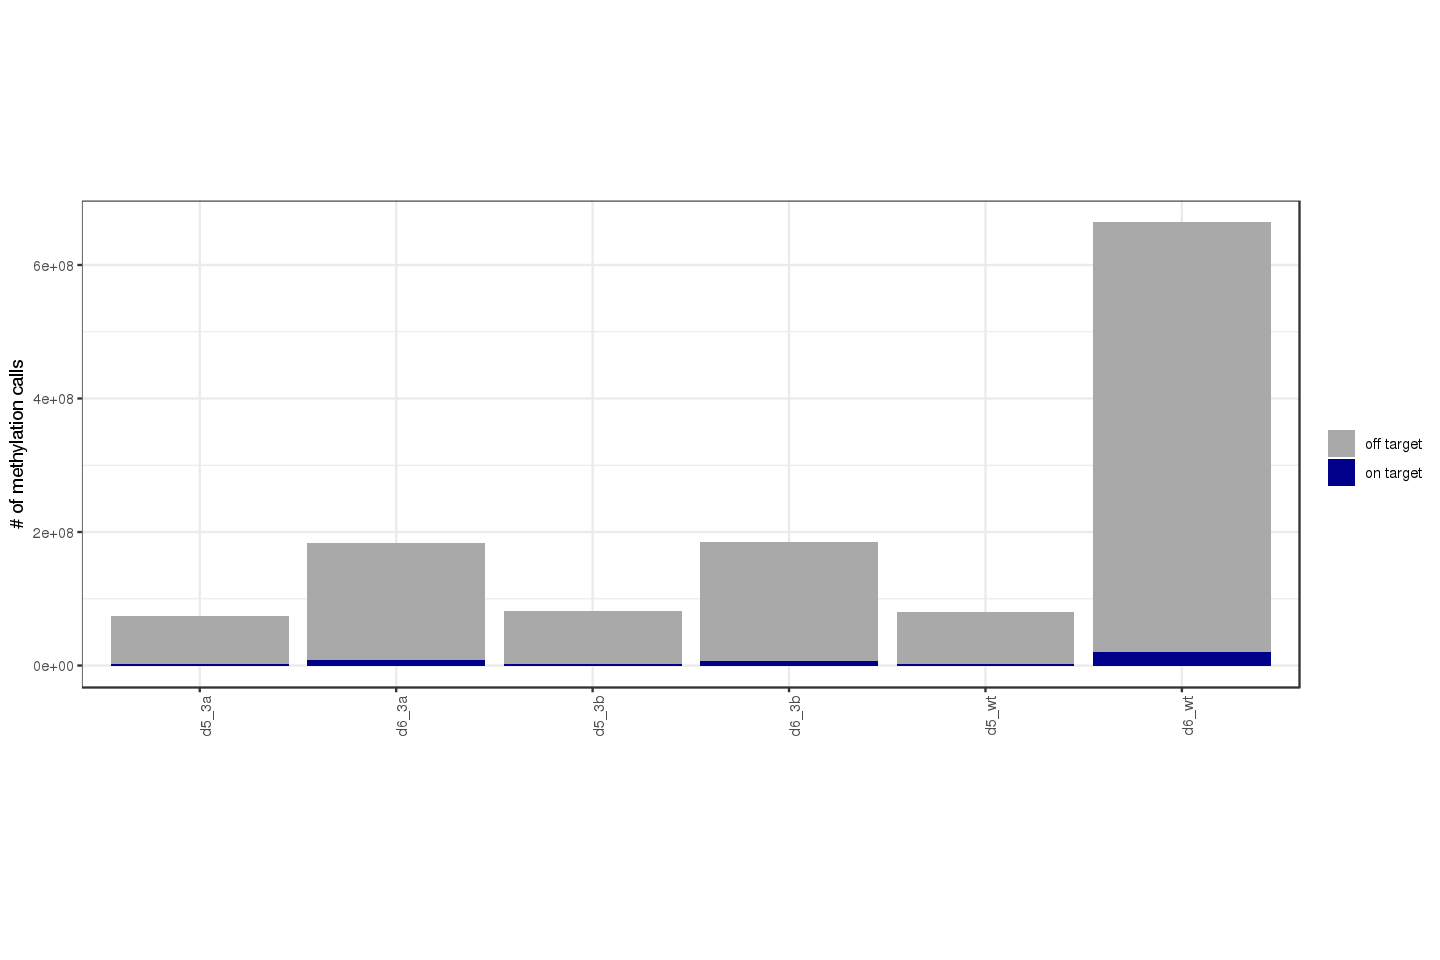

In [140]:
p_5_6 <- df %>%        
    filter(day %in% c("d5", "d6")) %>%    
    ggplot(aes(x=samp_id, y=num, fill=type)) + 
        geom_col() + 
        scale_fill_manual(name="", values=c("on target" = "darkblue", "off target" = "darkgray")) + 
        vertical_labs() + 
        scale_y_continuous(labels=scales::scientific) +         
        xlab('') + 
        ylab('# of methylation calls')        
p_5_6 + theme_bw() + vertical_labs() + theme(aspect.ratio=0.4)

Note that we calculate the "on target" based only on mapped reads that had at least one CpG.

Add to ppt:

In [141]:
plot_gg_ppt(p_0_4, here("figures/probes-coverage-stats.pptx"), width = 12, height = 5, sep_legend = TRUE, new_slide=TRUE)
plot_gg_ppt(p_5_6, here("figures/probes-coverage-stats.pptx"), width = 5, height = 5, sep_legend = TRUE, new_slide=TRUE)

## Global methylation trend

Global methylation is calculated based on CpGs that are not: 

- promoters
- putative enhancers
- part of a capture region ("on target")

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/global_meth.csv'



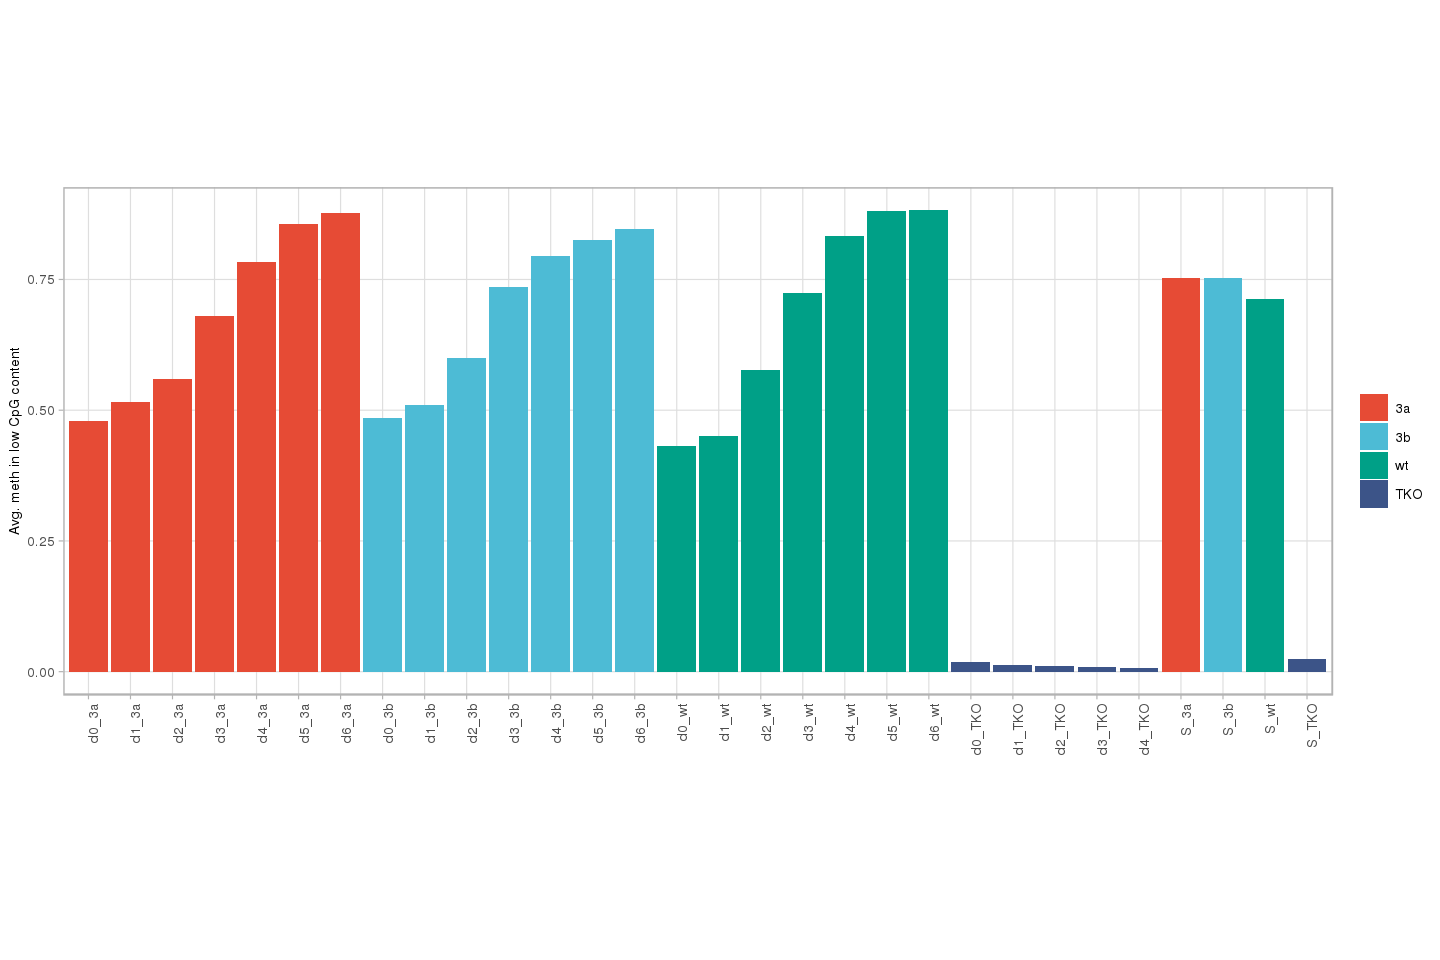

In [36]:
gmeth <- calc_global_meth() %cache_df% 
    here("output/global_meth.csv") %>%
    mutate(breaks = forcats::fct_recode(breaks, "2%-3%" = "(0.02,0.03]", "1%-2%" = "[0.01,0.02]", "8%-15%" = "(0.08,0.15]", "0%-3%" = "[0,0.03]")) %>% 
    filter(cg_num >= 1e4)
gmeth <- gmeth %>% 
    select(-cg_num) %>% 
    spread(breaks, meth) %>% 
    filter(samp_id %in% samp_levels_all) %>% 
    mutate(mut = factor(mut, levels = mut_levels_all), samp_id = factor(samp_id, levels=samp_levels_all))
p <- gmeth %>% 
    group_by(samp_id, mut) %>% 
    summarise(`0%-3%` = mean(`0%-3%`, na.rm=TRUE)) %>%     
    ggplot(aes(x=samp_id, y=`0%-3%`, fill=mut)) + geom_col() + ggsci::scale_fill_npg(name='') + vertical_labs()  + xlab('') + ylab('Avg. meth in low CpG content') + theme(aspect.ratio=0.4)
p

Add to ppt:

In [37]:
plot_gg_ppt(p, here("figures/probes-coverage-stats.pptx"), width = 12, height = 5, sep_legend = TRUE, new_slide=TRUE)

Avg. meth in high CpG content:

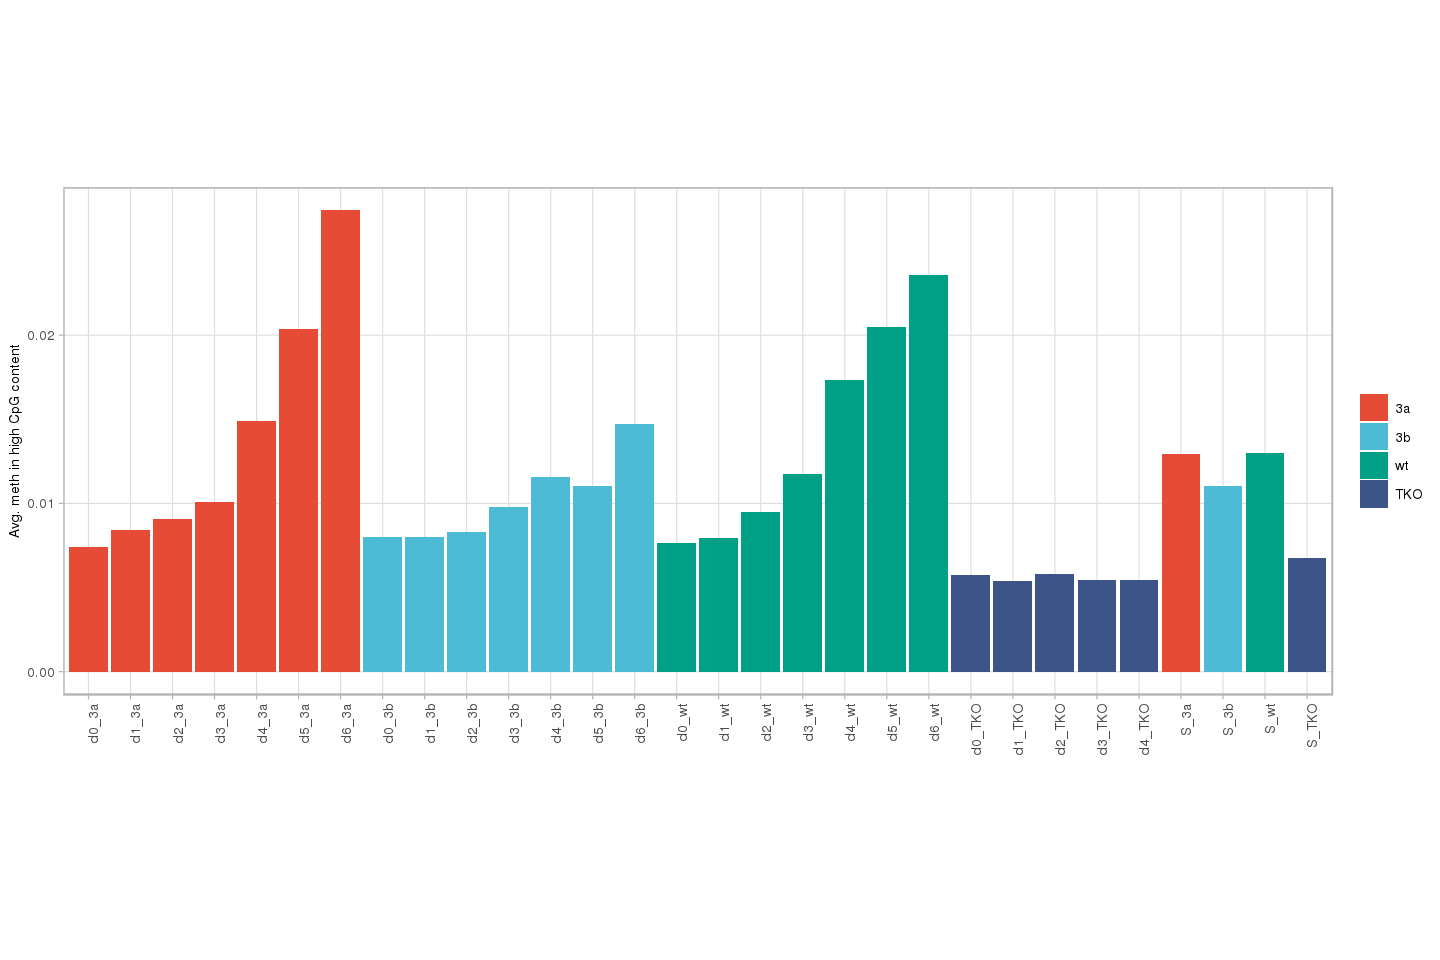

In [38]:
p <- gmeth %>%
    group_by(samp_id, mut) %>% 
    summarise(`8%-15%` = mean(`8%-15%`, na.rm=TRUE)) %>%   
    ggplot(aes(x=samp_id, y=`8%-15%`, fill=mut)) + geom_col() + ggsci::scale_fill_npg(name='') + vertical_labs()  + xlab('') + ylab('Avg. meth in high CpG content') + theme(aspect.ratio=0.4)
p